<a href="https://colab.research.google.com/github/BenxiaHu/Deep_learning_examples/blob/master/CNN_DNAmotif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Data Preparation

In [14]:
SEQUENCES_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # Remove empty sequences.
print(len(sequences))
# Let's print the first few sequences.
print(pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1),
                 columns=['Sequences']).head())

# Encoding the sequences
integer_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(categories='auto')

input_features = []
print(len(sequences[0]))
for sequence in sequences:
    integer_encoded = integer_encoder.fit_transform(list(sequence))
    integer_encoded = np.array(integer_encoded).reshape(-1, 1)
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    input_features.append(one_hot_encoded.toarray())

input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n', sequences[0][:10], '...', sequences[0][-10:])
print('One hot encoding of Sequence #1:\n', input_features[0].T)

# Encoding the labels
LABELS_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # Remove empty labels

one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n', labels.T)
print('One-hot encoded labels:\n', input_labels.T)

# Splitting the data
train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(train_features, dtype=torch.float32)
y_train = torch.tensor(train_labels, dtype=torch.float32)
X_val = torch.tensor(test_features, dtype=torch.float32)
y_val = torch.tensor(test_labels, dtype=torch.float32)

print(X_train.shape)
# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

2000
                                           Sequences
1  CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
2  GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
3  GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
4  GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...
5  GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...
50
Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.
  0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
  0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0.
  1. 1.]
 [0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0.
  0. 0. 0.

# Model Definition

In [3]:
class DNAConvNet(nn.Module):
    def __init__(self):
        super(DNAConvNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=32, kernel_size=12)
        self.pool1 = nn.MaxPool1d(kernel_size=4)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * ((train_features.shape[1] - 12 + 1) // 4), 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Initialize the model, loss function, and optimizer
model = DNAConvNet()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print model summary
print(model)

DNAConvNet(
  (conv1): Conv1d(4, 32, kernel_size=(12,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=288, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)


# Training Loop

In [4]:
num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        # Transpose inputs to (batch_size, channels, sequence_length)
        inputs = inputs.transpose(1, 2)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        _, true_labels = torch.max(labels, 1)
        total += labels.size(0)
        correct += (predicted == true_labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.transpose(1, 2)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            _, true_labels = torch.max(labels, 1)
            val_total += labels.size(0)
            val_correct += (predicted == true_labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | '
              f'Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}')

Epoch 1/50 | Train Loss: 0.6809 | Train Acc: 0.5693 | Val Loss: 0.6529 | Val Acc: 0.6080
Epoch 10/50 | Train Loss: 0.0787 | Train Acc: 0.9827 | Val Loss: 0.0892 | Val Acc: 0.9720
Epoch 20/50 | Train Loss: 0.0204 | Train Acc: 0.9980 | Val Loss: 0.0848 | Val Acc: 0.9700
Epoch 30/50 | Train Loss: 0.0072 | Train Acc: 0.9993 | Val Loss: 0.0871 | Val Acc: 0.9640
Epoch 40/50 | Train Loss: 0.0019 | Train Acc: 1.0000 | Val Loss: 0.0781 | Val Acc: 0.9760
Epoch 50/50 | Train Loss: 0.0009 | Train Acc: 1.0000 | Val Loss: 0.0846 | Val Acc: 0.9760


# Plotting Loss and Accuracy

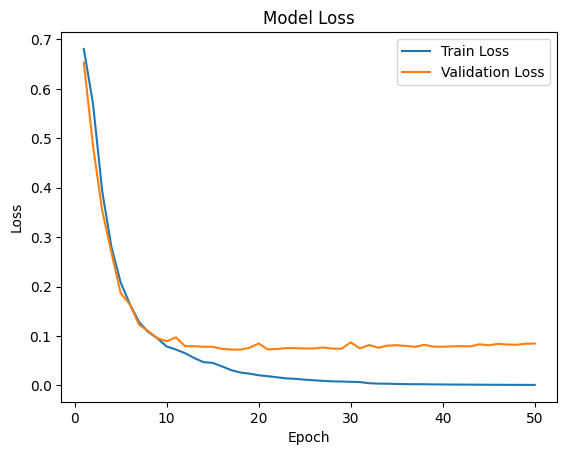

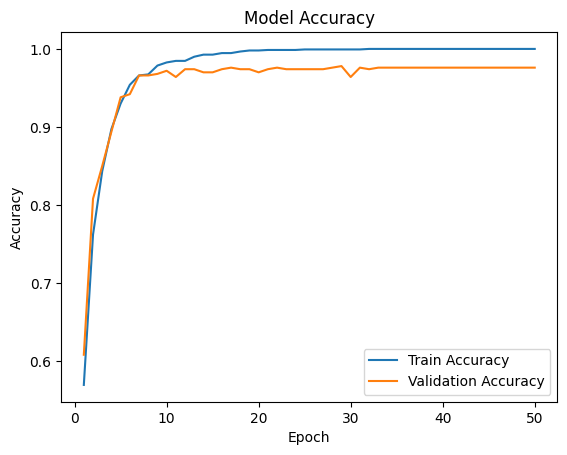

In [5]:
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluation

Confusion matrix:
 [[251   8]
 [  4 237]]


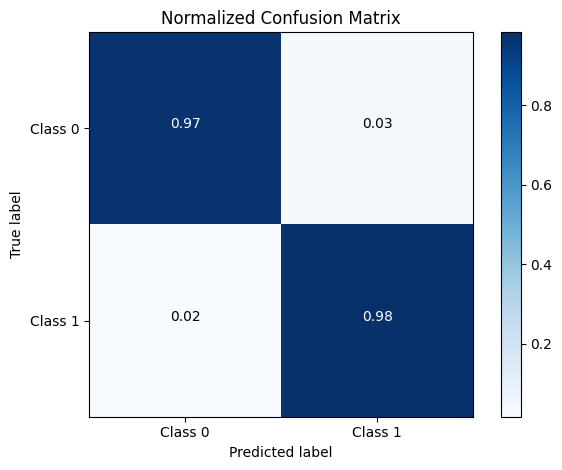

In [6]:
# Move model to evaluation mode
model.eval()

# Predict on validation set
all_preds = []
all_true = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.transpose(1, 2)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        _, true_labels = torch.max(labels, 1)
        all_preds.extend(predicted.numpy())
        all_true.extend(true_labels.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_true, all_preds)
print('Confusion matrix:\n', cm)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Class 0', 'Class 1'])
plt.yticks(tick_marks, ['Class 0', 'Class 1'])

fmt = '.2f'
thresh = cm_normalized.max() / 2.
for i, j in itertools.product(range(cm_normalized.shape[0]), range(cm_normalized.shape[1])):
    plt.text(j, i, format(cm_normalized[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm_normalized[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Saliency Map

Number of test samples: 500
Selected sequence index for saliency map: 276


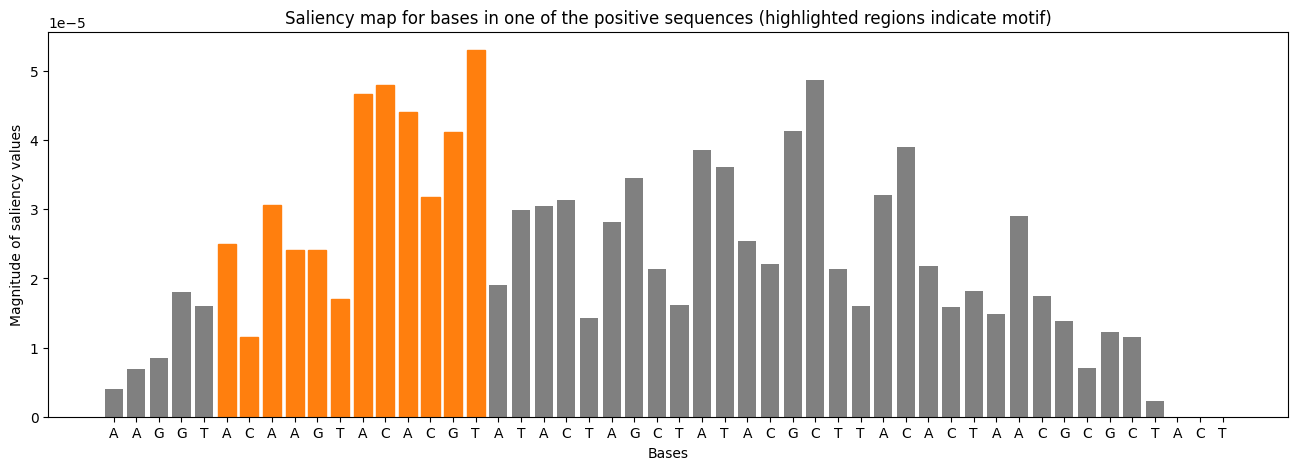

In [10]:
def compute_salient_bases(model, x):
    model.eval()
    # x is expected to be a NumPy array; convert it to a PyTorch tensor
    x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).transpose(1, 2)
    x_tensor.requires_grad = True

    output = model(x_tensor)
    target = output[0, 1]  # Assuming class 1 is the positive class
    target.backward()

    gradients = x_tensor.grad.data.numpy()[0]  # Shape: (4, sequence_length)
    saliency = np.clip(np.sum(np.abs(gradients), axis=0), a_min=0, a_max=None)
    return saliency

# Verify the size of X_val
num_test_samples = X_val.shape[0]
print(f"Number of test samples: {num_test_samples}")

# Select a valid sequence index
# Option 1: Select the last index
# sequence_index = num_test_samples - 1  # e.g., 499 if num_test_samples = 500

# Option 2: Choose a random index
import random
sequence_index = random.randint(0, num_test_samples - 1)
print(f"Selected sequence index for saliency map: {sequence_index}")

# Compute saliency using X_val instead of test_features
sal = compute_salient_bases(model, X_val[sequence_index].detach().numpy())

# Plot the saliency map
plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal, color='grey')  # Default color

# Highlight specific bases if needed
# Adjust the range based on your motif's expected location
# For example, highlighting positions 5 to 16
highlight_start = 5
highlight_end = 17  # Exclusive
for i in range(highlight_start, highlight_end):
    if i < len(barlist):
        barlist[i].set_color('C1')  # Change to desired color

plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]))
plt.title('Saliency map for bases in one of the positive sequences'
          ' (highlighted regions indicate motif)')
plt.show()